In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
words = open('../names.txt', 'r').read().splitlines()
chrs = sorted(list(set(''.join(words))))

stoi = {s:i + 1 for i, s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [76]:
# parameters
vocab_size = len(itos)
block_size = 8
batch_size = 32
g = torch.Generator().manual_seed(1337)
n_embd = 24
n_hidden = 128

#params
C = torch.randn((vocab_size, n_embd), generator=g)


In [77]:
# build dataset

def build_dataset(words, block_size=block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.size(), Y.size())
    return X, Y

random.seed(1337)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182587, 8]) torch.Size([182587])
torch.Size([22780, 8]) torch.Size([22780])
torch.Size([22779, 8]) torch.Size([22779])


In [78]:
for x, y in zip(Xtr[:10], Ytr[:10]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> w
.......w --> e
......we --> s
.....wes --> s
....wess --> o
...wesso --> n
..wesson --> .
........ --> e
.......e --> y
......ey --> r


In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)
        self.bias = torch.randn(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # memory
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate forward
        if self.training:
            if x.ndim == 2:  # output layer: compute mean/var over the batch, i.e., dim=0
                dim = 0
            elif x.ndim == 3:  # compute mean/var over both batch and time dimensions, i.e., dim=(0, 1)
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the memory
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.size()
        x = x.view(B, T//self.n, C*self.n)
        if x.size(1) == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        #get all params
        return [p for layer in self.layers for p in layer.parameters()]


In [80]:
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2,     n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [81]:
# optimization
max_steps = 20000
lossi = []
ud = []

for step in range(max_steps):

    # minibatch
    b_ix = torch.randint(0, Xtr.size(0), (batch_size,), generator=g)
    Xb, Yb = Xtr[b_ix], Ytr[b_ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if step < 500 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if step % 1000 == 0:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f} :lr={lr}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([lr*p.grad.std()/p.data.std().log10().item() for p in parameters])
    
    # break
    # if step > 200:
    #     break


      0/  20000: 4.4454 :lr=0.1
   1000/  20000: 2.0543 :lr=0.01
   2000/  20000: 2.2746 :lr=0.01
   3000/  20000: 2.5270 :lr=0.01
   4000/  20000: 2.0747 :lr=0.01
   5000/  20000: 2.7762 :lr=0.01
   6000/  20000: 2.6165 :lr=0.01
   7000/  20000: 2.2860 :lr=0.01
   8000/  20000: 2.3439 :lr=0.01
   9000/  20000: 2.6263 :lr=0.01
  10000/  20000: 2.4504 :lr=0.01
  11000/  20000: 2.0801 :lr=0.01
  12000/  20000: 2.3582 :lr=0.01
  13000/  20000: 2.1157 :lr=0.01
  14000/  20000: 2.0281 :lr=0.01
  15000/  20000: 2.3666 :lr=0.01
  16000/  20000: 2.0609 :lr=0.01
  17000/  20000: 2.5642 :lr=0.01
  18000/  20000: 2.3993 :lr=0.01
  19000/  20000: 2.6326 :lr=0.01


In [82]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


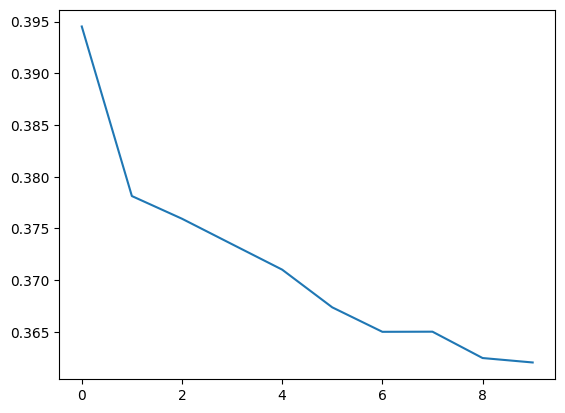

In [83]:
plt.plot(torch.tensor(lossi[:max_steps]).view(-1, int((max_steps/10))).mean(1))

In [84]:
# to eval mode
for layer in model.layers:
    layer.training = False

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2863876819610596
val 2.2988719940185547


In [86]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

zedfl.
abxlopey.
dindre.
madken.
saydelar.
akeynen.
echoriah.
jeane.
jurastor.
brlas.
mayes.
tianuew.
kenvan.
tshon.
keliano.
ziaish.
lcinttasg.
auri.
brinetan.
milyah.
